In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import pandas as pd
import pickle

Using TensorFlow backend.


In [287]:
batch_size = 64  # Batch size for training.
epochs = 20  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

# The pickle file you get the 1st notebook - Data Preprocessing/Augmentation
# Path to the data txt file on disk.
data_path = '/Users/vikramanksingh/Downloads/augmented_data.pkl'

In [4]:
import _pickle as cPickle
with open(data_path, 'rb') as fo:
        dict = cPickle.load(fo)

In [5]:
# Load the data file which has the input to output mappings
with open (data_path, 'rb') as fp:
    encoded_data = pickle.load(fp)

In [8]:
encoded_data = encoded_data[['user', 'inp', 'out']]

In [86]:
from sklearn.utils import shuffle
enc_data = shuffle(encoded_data)

In [87]:
# Spliting the data into test and train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(enc_data['inp'], enc_data['out'], test_size=0.33, random_state=42)

In [88]:
max_encoder_seq_length = max([len(txt) for txt in encoded_data['inp']])
max_decoder_seq_length = max([len(txt) for txt in encoded_data['out']])

In [89]:
num_encoder_tokens = len(X_train.iloc[0][0])
num_decoder_tokens = len(y_train.iloc[0][0])

In [202]:
max_encoder_seq_length
zero_vec = np.zeros(13)

def pad(vec, max_seq_length):
    global zero_vec
    arr = []
    for v in vec:
        arr.append(np.array(v))
    for i in range(max_seq_length - len(vec)):
        arr.append(zero_vec)
    return arr

In [239]:

X_train_df = pd.DataFrame(X_train)
X_train_df['inp'] = X_train_df.apply(lambda x: pad(x['inp'], max_encoder_seq_length), axis = 1)

X_test_df = pd.DataFrame(X_test)
X_test_df['inp'] = X_test_df.apply(lambda x: pad(x['inp'], max_encoder_seq_length), axis = 1)

y_train_df = pd.DataFrame(y_train)
y_train_df['out'] = y_train_df.apply(lambda x: pad(x['out'], max_decoder_seq_length), axis = 1)

y_test_df = pd.DataFrame(y_test)
y_test_df['out'] = y_test_df.apply(lambda x: pad(x['out'], max_decoder_seq_length), axis = 1)

In [119]:
y_test_df.shape

(621, 1)

In [260]:

X_train_arr = np.concatenate(X_train_df.values.flatten()).reshape((1258,166,13))
X_test_arr = np.concatenate(X_test_df.values.flatten()).reshape((621,166,13))

y_train_arr = np.concatenate(y_train_df.values.flatten()).reshape((1258,39,13))
y_test_arr = np.concatenate(y_test_df.values.flatten()).reshape((621,39,13))

In [261]:
print(X_train_arr.shape, y_train_arr.shape)
print(X_test_arr.shape, y_test_arr.shape)

(1258, 166, 13) (1258, 39, 13)
(621, 166, 13) (621, 39, 13)


In [274]:
encoder_input_data.shape

(1258, 166, 13)

In [275]:
decoder_target_data.shape

(1258, 39, 13)

In [279]:
decoder_input_data = decoder_target_data

In [299]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs)
# Save model
model.save('s2s.h5')


Epoch 1/20
1258/1258 [==============================] - 16s 12ms/step - loss: 0.1890 - acc: 0.4836
Epoch 2/20
1258/1258 [==============================] - 13s 10ms/step - loss: 0.1449 - acc: 0.7112
Epoch 3/20
1258/1258 [==============================] - 13s 10ms/step - loss: 0.1098 - acc: 0.7347
Epoch 4/20
1258/1258 [==============================] - 12s 10ms/step - loss: 0.0807 - acc: 0.8078
Epoch 5/20
1258/1258 [==============================] - 13s 10ms/step - loss: 0.0645 - acc: 0.8293
Epoch 6/20
1258/1258 [==============================] - 14s 11ms/step - loss: 0.0601 - acc: 0.8021
Epoch 7/20
1258/1258 [==============================] - 19s 15ms/step - loss: 0.0526 - acc: 0.8500
Epoch 8/20
1258/1258 [==============================] - 13s 11ms/step - loss: 0.0496 - acc: 0.8302
Epoch 9/20
1258/1258 [==============================] - 14s 11ms/step - loss: 0.0473 - acc: 0.8539
Epoch 10/20
1258/1258 [==============================] - 13s 10ms/step - loss: 0.0454 - acc: 0.8620
Epoch 11/

/Users/vikramanksingh/anaconda/envs/vik/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_20 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_19/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_19/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [329]:
print(history.history.values())

dict_values([[0.18899431286915686, 0.14486499743118575, 0.10983580015658953, 0.08073979812794156, 0.06446608617925492, 0.060065547729855694, 0.05257551620798763, 0.04961552003632479, 0.04732740929850713, 0.04536535583779998, 0.04370465755036222, 0.04247934922031075, 0.04133582982828393, 0.04047622814750823, 0.039741574962059295, 0.03893482961080412, 0.038292170305320304, 0.03759101924852176, 0.03745447552284679, 0.036895742749466616], [0.48359218699374906, 0.7112429131574586, 0.7347437972484219, 0.8078145986520618, 0.8292568563846412, 0.8021279164073198, 0.8500061153607452, 0.8301944531772777, 0.8538583835471416, 0.861950183521204, 0.8768700803785521, 0.8693082266278411, 0.8604215013014304, 0.8515144038844753, 0.8789287010512784, 0.8510456118371414, 0.8553055266128625, 0.8719171645720926, 0.8548367363659869, 0.8683094865566975]])


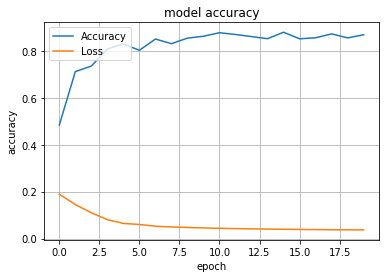

In [336]:
# import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [304]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states


# Define inference models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [326]:
############################################################################
############################################################################
# TODO -- Might consist bugs, didn't get time to debug this part of code
############################################################################
############################################################################

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    print("s:", np.array(states_value).shape)
    sample_state = np.array([np.zeros(num_decoder_tokens)])
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, max_decoder_seq_length, num_decoder_tokens))

    # Inference loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [sample_state] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sample_state = np.zeros(num_decoder_tokens)
        sample_state[sampled_token_index] = 1
        decoded_sentence.append(sample_state)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_token_index == 12 or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        states_value = [h, c]

    return decoded_sentence

In [333]:
############################################################################
############################################################################
# TODO -- Might consist bugs, didn't get time to debug this part of code
############################################################################
############################################################################

for seq_index in range(len(X_test_arr)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = np.array([X_test_arr[seq_index]])
    print(input_seq.shape)
    print('Input encoded sentence:', input_seq)
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    
    print('Decoded sentence:', decoded_sentence)